<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/Phase1/Phase1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Download Dataset from kaggle

In [ ]:
# !ls -lha kaggle.json
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d shayanfazeli/heartbeat -p /content
# !unzip /content/heartbeat.zip -d /content/heartbeat

# Import Libraries

In [8]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import (Input, Dense, LeakyReLU, Softmax, InputLayer, concatenate, Conv1D, MaxPool1D, Add, MaxPooling1D
 , Flatten, Dropout, ReLU, BatchNormalization, GlobalAveragePooling1D)
from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from random import uniform 
import random


from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix


# Load data and count categories 

In [9]:
train_df=pd.read_csv('/content/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

In [ ]:
# train_df = train_df[:186].astype('float16')
# test_df = test_df[:186].astype('float16')

In [10]:
train_df[187]=train_df[187].astype(int)
counter=train_df[187].value_counts()
print(counter)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


# Balancing the data

In [11]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=10000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=10000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=10000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=10000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=10000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [12]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [13]:
equilibre=train_df[187].value_counts()
print(equilibre)

0    10000
1    10000
2    10000
3    10000
4    10000
Name: 187, dtype: int64


In [14]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
63240,1.000000,0.728571,0.248571,0.000000,0.100000,0.085714,0.088571,0.054286,0.062857,0.042857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72965,1.000000,0.866109,0.280335,0.062762,0.104603,0.171548,0.163180,0.184100,0.225941,0.192469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
80392,0.786693,0.733855,0.455969,0.086106,0.037182,0.000000,0.015656,0.029354,0.072407,0.183953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80635,1.000000,0.952468,0.469835,0.210238,0.140768,0.142596,0.111517,0.113346,0.100548,0.104205,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86165,0.789969,0.684953,0.581505,0.457680,0.341693,0.199060,0.115987,0.036050,0.017241,0.023511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
# del c

# Adding some noise

In [15]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

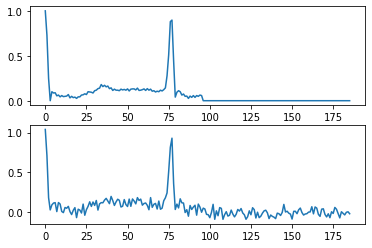

In [16]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [17]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [18]:
train_df = train_df.astype('float16')
test_df = test_df.astype('float16')

X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
# X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
# X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [19]:
print(X_train.shape)
print(X_test.shape)

(50000, 186)
(21892, 186)


# Data Agumentation

In [20]:
# data augmentation

def augmetation(X_train, y_train, chance):

  augment_number = 0
  XF_train = np.zeros((X_train.shape[0]*2, X_train.shape[1]))
  yf_train = np.zeros((y_train.shape[0]*2, y_train.shape[1]))
  pointer = 0
  for index, row in enumerate(X_train):

    XF_train[pointer, :] = row
    yf_train[pointer, :] = y_train[index, :]
    pointer += 1

    rand_num = random.uniform(0, 1)      
    if chance > rand_num :

      augment_number += 1
      noise = np.random.normal(0,0.05,186)
      new_signal = row + noise  
      XF_train[pointer, :] = new_signal
      yf_train[pointer, :] = y_train[index, :]
      pointer += 1

      filled = X_train.shape[0] + augment_number
      XFF_train = XF_train[:filled, :]
      yff_train = yf_train[:filled, :]

    
  return XFF_train, yff_train


In [21]:
X_train, y_train = augmetation(X_train, y_train, 0.1)

Extending the ECG signal periodically so that it can be used in phase two!

In [22]:
# periodic signal extend 

import pywt

XF_train = np.zeros((X_train.shape[0], 9000))
XF_test = np.zeros((X_test.shape[0], 9000))


for index, row in enumerate(X_train):
  XF_train[index, :] = pywt.pad(row, 4407, 'periodic')


for index, row in enumerate(X_test):
  XF_test[index, :] = pywt.pad(row, 4407, 'periodic')

In [23]:
XF_train = XF_train.reshape((XF_train.shape[0], 9000, 1))
XF_test = XF_test.reshape((XF_test.shape[0], 9000, 1))

In [24]:
print("X_train : ", XF_train.shape)
print("Y_train : ", y_train.shape)
print("X_test : ", XF_test.shape)
print("Y_test : ", y_test.shape)

X_train :  (55023, 9000, 1)
Y_train :  (55023, 5)
X_test :  (21892, 9000, 1)
Y_test :  (21892, 5)


# Here we define our model!

In [25]:
X_input = Input(shape=(9000, 1))
Conv = Conv1D(filters=64, kernel_size=5, strides=3)(X_input)


### step 1 

Conv1_1 = Conv1D(filters=64, kernel_size=9, strides=1, padding='same')(Conv)
Bn1_1 = BatchNormalization()(Conv1_1)
Act1_1 = LeakyReLU()(Bn1_1)
Conv1_2 = Conv1D(filters=64, kernel_size=7, strides=1, padding='same')(Act1_1)
Bn1_2 = BatchNormalization()(Conv1_2)
Act1_2 = LeakyReLU()(Bn1_2)
DO1_1 = Dropout(0.2)(Act1_2)
Conv1_3 = Conv1D(filters=64, kernel_size=9, strides=1, padding='same')(DO1_1)
Bn1_3 = BatchNormalization()(Conv1_3)
shortcut1_1 = Add()([Bn1_3, Conv])
Bn1_4 = BatchNormalization()(shortcut1_1)
Act1_3 = LeakyReLU()(Bn1_4)
##### auxiliary
Conv1_4 = Conv1D(filters=128, kernel_size=7, strides=3, padding='same')(Act1_3)
Bn1_5 = BatchNormalization()(Conv1_4)
Act1_4 = LeakyReLU()(Bn1_5)
###############
Max1_1 = MaxPooling1D(pool_size=5, strides=2)(Act1_4)


## step 2

Conv2_1 = Conv1D(filters=256, kernel_size=3, strides=1, padding='same')(Max1_1)
Bn2_1 = BatchNormalization()(Conv2_1)
Act2_1 = LeakyReLU()(Bn2_1)
Conv2_2 = Conv1D(filters=256, kernel_size=5, strides=1, padding='same')(Act2_1)
Bn2_2 = BatchNormalization()(Conv2_2)
Act2_2 = LeakyReLU()(Bn2_2)
DO2_1 = Dropout(0.2)(Act2_2)
Conv2_3 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(DO2_1)
Bn2_3 = BatchNormalization()(Conv2_3)
shortcut2_1 = Add()([Bn2_3, Max1_1])
Bn2_4 = BatchNormalization()(shortcut2_1)
Act2_3 = LeakyReLU()(Bn2_4)
##### auxiliary
Conv2_4 = Conv1D(filters=512, kernel_size=7, strides=2, padding='same')(Act2_3)
Bn2_5 = BatchNormalization()(Conv2_4)
Act2_4 = LeakyReLU()(Bn2_5)
###############
Max2_1 = MaxPooling1D(pool_size=5, strides=3)(Act2_4)



Flat1 = Flatten()(Max2_1)

D1 = Dense(256)(Flat1)
A6 = LeakyReLU()(D1)
D_O = Dropout(0.15)(A6)
D2 = Dense(128)(D_O)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=X_input, outputs=A7)

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9000, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2999, 64)     384         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2999, 64)     36928       ['conv1d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 2999, 64)    256         ['conv1d_1[0][0]']               
 alization)                                                                                   

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1719,
    decay_rate=0.7)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early Stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(XF_train, y_train, epochs=6, batch_size=64, validation_data=(XF_test, y_test), callbacks=[es_callback])

Epoch 1/6
860/860 [==============================] - 7071s 8s/step - loss: 4.2049 - accuracy: 0.6377 - val_loss: 0.9458 - val_accuracy: 0.8428
Epoch 2/6
860/860 [==============================] - 7109s 8s/step - loss: 0.3608 - accuracy: 0.8763 - val_loss: 0.4492 - val_accuracy: 0.8518
Epoch 3/6
860/860 [==============================] - 7178s 8s/step - loss: 0.2508 - accuracy: 0.9151 - val_loss: 0.3316 - val_accuracy: 0.8908
Epoch 4/6
860/860 [==============================] - 7210s 8s/step - loss: 0.1854 - accuracy: 0.9357 - val_loss: 0.3050 - val_accuracy: 0.9056
Epoch 5/6
860/860 [==============================] - 7172s 8s/step - loss: 0.1939 - accuracy: 0.9393 - val_loss: 0.3331 - val_accuracy: 0.9111
Epoch 6/6
113/860 [==>...........................] - ETA: 1:34:13 - loss: 0.1415 - accuracy: 0.9519

In [ ]:
# evaluate the model
scores = model.evaluate(XF_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# save model and architecture to single file
model.save("/content/drive/My Drive/Cardio/HeartBeat.h5")